<div class="alert alert-block alert-success">
    
# FIT5196 Task 1 in Assessment 1
#### Student Name: Dam Minh Trang Pham, Hengyu Zhang
#### Student ID: 30102804, 31278299

Date: 16 April 2024


Environment: Google Colab

Libraries used:
* re (for regular expression, installed and imported)
* pandas (for data manipulation)
* json (for writing json output)
    
</div>

<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Examining Patent Files](#examine) <br>
[4. Loading and Parsing Files](#load) <br>
$\;\;\;\;$[4.1. Defining Regular Expressions](#Reg_Exp) <br>
$\;\;\;\;$[4.2. RCreate the function to remove title and mapping country](#Read) <br>
$\;\;\;\;$[4.3. Create the dictionary that store all extracted values and extract information from text file](#latin) <br>
[5. Writing to CSV/JSON File](#write) <br>
$\;\;\;\;$[5.1. Verification of the Generated XML File](#test_xml) <br>
[6. Summary](#summary) <br>
[7. References](#Ref) <br>



-------------------------------------

<div class="alert alert-block alert-warning">

## 1.  Introduction  <a class="anchor" name="Intro"></a>
    
</div>

This assessment regards extracting data from semi-sctuctured text files. The dataset contained 500 `.txt` files which included various information about assignment entries. In particular, each entry contains reel number, frame number, timestamps, metadata on assignors and assignees. The goal of this assessment is to parse these text files, extract the relevant information, and organize it into a structured format for further analysis.

-------------------------------------

<div class="alert alert-block alert-warning">
    
## 2.  Importing Libraries  <a class="anchor" name="libs"></a>
 </div>

The packages to be used in this assessment are imported in the following. They are used to fulfill the following tasks:

* **re:** to define and use regular expressions
* **pandas:** for data manipulation, handling of structured data
* **json** to write the json output file

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import re
import pandas as pd
import json

-------------------------------------

<div class="alert alert-block alert-warning">

## 3.  Examining Raw Data <a class="anchor" name="examine"></a>

 </div>

First of all, we examine the raw .txt file.

Having examined the file content, the following observations were made:

* The file is in XML format, containing information on assignments
* The only XML special character found is '&amp'
* Each assignment entry element is represented by <assignment-entry>
* Within each <assignment-entry>, there are several child elements such as <assignment>, <assignors>, <assignees>, and <properties>, each containing specific information about the assignment
* The <assignment> element includes details such as reel number, frame number, last update date, conveyance text, etc.
* The <assignors> and <assignees> elements contain information about the parties involved in the assignment, including their names, addresses, legal entity types, etc. Since there might be multiple assignors or/and assignees in 1 assignment entry, we need to create loop iterating through these.
* The <properties> element provides details about the properties being assigned, such as serial numbers and registration numbers



-------------------------------------

<div class="alert alert-block alert-warning">

## 4.  Loading and Parsing Files <a class="anchor" name="load"></a>

</div>

In this section, the files are parsed and processed. First of all, read the text file and convert the XML special characters. Then, appropriate regular expressions are defined to extract desired information when reading the files.

In [37]:
#Read the text file, encoding as utf-8
with open('/content/drive/Shareddrives/FIT5196_S1_2024/A1/Students data/Task 1/Group068.txt', 'r', encoding = "utf-8") as f:
    data = f.read()

In [38]:
#Convert special XML characters
data = data.replace('&amp;', '')
data = data.replace('&;', '')

-------------------------------------

<div class="alert alert-block alert-info">
    
### 4.1. Defining Regular Expressions <a class="anchor" name="Reg_Exp"></a>

Defining correct regular expressions is crucial in extracting desired information from the text efficiently. <br>

For most of the text and pattern, we are using (.*?) to match the information between tags. <br>

For dates, we are using (\d{8}) pattern to precisely capture 8 digits character. And for conveyance text, use the stronger pattern to capture everything between the tag including spaces.

In [39]:
pattern_assignment_entries = r'<assignment-entry>(.*?)</assignment-entry>' #reg ex pattern for 1 assignment entry
pattern_reel_no = r'<reel-no>(.*?)</reel-no>' #reg ex pattern for reel no
pattern_frame_no = r'<frame-no>(.*?)</frame-no>' #reg ex pattern for frame no
pattern_last_update_date = r'<last-update-date>(\d{8})</last-update-date>' #reg ex pattern for last update date
pattern_conveyance_text = r'<conveyance-text[^>]*>([^<]+)</conveyance-text>' #reg ex pattern for last convayence text
#For correspondent party name, the pattern is having <correspondent> with the space (line break) before the name tag.
pattern_correspondent_party = r'<correspondent>\s*<person-or-organization-name>(.*?)</person-or-organization-name>' #reg ex pattern for correspondent party name

pattern_assignor = r'<assignor>(.*?)</assignor>' #reg ex pattern for assignor information
pattern_assignee = r'<assignee>(.*?)</assignee>' #reg ex pattern for assignee information
pattern_party_name = r'<person-or-organization-name>(.*?)</person-or-organization-name>' #reg ex pattern for assignor or assignee party name
pattern_ackowledge_date = r'<date-acknowledged>(\d{8})</date-acknowledged>' #reg ex pattern for acknowledge date
party_execution_date = r'<execution-date>(\d{8})</execution-date>' #reg ex pattern for execution date
pattern_country_name = r'<country-name>(.*?)</country-name>' #reg ex pattern for country name
pattern_state = r'<state>(.*?)</state>' #reg ex pattern for state name
pattern_nationality = r'<nationality>(.*?)</nationality>' #reg ex pattern for nationality
pattern_legal_entity_text = r'<legal-entity-text>(.*?)</legal-entity-text>' #reg ex pattern for legal entity text

pattern_properties_section = r'<properties>(.*?)</properties>' #reg ex pattern for properties section
pattern_property = r'<property>(.*?)</property>' #reg ex pattern for each property

pattern_remove_title_mr_ms = r',\s*(MR\.|MS\.|DR\.)$' #reg ex pattern for removing MR. or MS. title at the end

These patterns are used in the next step when reading the files.

-------------------------------------

<div class="alert alert-block alert-info">
    
### 4.2. Create the function to remove title and mapping country <a class="anchor" name="Read"></a>

#### Title insight:
* The title 'MR.' can be at the beginning, in the middle or at the end (with the comma before).
* All MISS are company
* MMAG. DR. MARKUS FELLNER - UNKNOWN but its an individual
* "Mx", "Dame", "Dr", "Cllr", "Lady", "Lord" or 'Sir' do not appear in the title text.

In [40]:
#Create a function to remove title
titles = ['MR.', 'DR.', 'MRS.', 'Sir']

#The function will take in 2 variables, name and legal entity text
def remove_title(name, legal_entity):
  #If the legal entity text if not individual or unknown, it will return original name
  if legal_entity != 'INDIVIDUAL' and legal_entity != 'UNKNOWN':
    return name
  #If legal entity is individual and it matches the pattern (MR. or MS. at the end of name), will remove title
  elif legal_entity == 'INDIVIDUAL' and re.search(pattern_remove_title_mr_ms, name):
    return re.sub(pattern_remove_title_mr_ms, '', name).strip()
  #Check for the rest legal entity, if it contains titles (MR. or DR.) then remove title. I have checked the data and other titles are not included in this data.
  elif legal_entity == 'INDIVIDUAL':
    texts = name.split()
    clean_texts = [text for text in texts if text not in titles]
    new_name = ' '.join(clean_texts)
    return new_name
  #If the legal entity is unknown, the only case is MMAG. DR. MARKUS FELLNER, then remove title
  elif legal_entity == 'UNKNOWN':
    if 'DR.' in name and 'MMAG.' in name:
      texts = name.split()
      clean_texts = [text for text in texts if text not in titles]
      new_name = ' '.join(clean_texts)
      return new_name
    else:
      return name
  #If not satisfy any case above, return the original name
  else:
    return name

In [41]:
#Test the function with few cases:
remove_title('CAYTON, DAVID, MR.', 'INDIVIDUAL')

'CAYTON, DAVID'

In [42]:
remove_title('HOCH, MR. ROBERT', 'INDIVIDUAL')

'HOCH, ROBERT'

In [43]:
remove_title('MR. CROISSANT, INC.', 'CORPORATION')

'MR. CROISSANT, INC.'

In [44]:
remove_title('MMAG. DR. MARKUS FELLNER', 'UNKNOWN')

'MMAG. MARKUS FELLNER'

In [45]:
remove_title('DR. AUSBÜTTEL &; CO. GMBH', 'UNKNOWN')

'DR. AUSBÜTTEL &; CO. GMBH'

#### Country Insight:
* For country name and state variables, there is no Unknown or Not Provided value, only Nationality have Not Provided value.
* Some Canada provinces are mistaken as Country.

In [46]:
#Create a function to map country name
us_variants = [ 'US', 'AMERICA', 'UNITED STATES']
uk_variants = ['UNITED KINGDOM', 'ENGLAND', 'SCOTLAND', 'WALES', 'NORTHERN IRELAND']

us_states = [ 'ALABAMA', 'ALASKA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'HAWAII', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING', 'DISTRICT OF COLUMBIA']
canada_provinces = [ 'ALBERTA', 'BRITISH COLUMBIA', 'MANITOBA', 'NEW BRUNSWICK', 'NEWFOUNDLAND AND LABRADOR', 'NOVA SCOTIA', 'ONTARIO', 'PRINCE EDWARD ISLAND', 'QUEBEC', 'SASKATCHEWAN', 'NORTHWEST TERRITORIES', 'NUNAVUT', 'YUKON']

#Check if there is country variable, then if country is not available, then state, then nationality accordingly.
#If all 3 variables information are unavailable return NA
#Also, if country and state are not available, and state is 'NOT PROVIDED' return NA. (there is no STATELESS in this data)
def country_mapping(c, s, n):
  if c:
    if c in us_variants:
      return 'USA'
    elif c in uk_variants:
      return 'UK'
    else:
      return c

  elif s:
    if s in us_states:
      return 'USA'
    elif s in canada_provinces:
      return 'CANADA'
    else:
      return s

  elif n:
    if n in us_variants:
      return 'USA'
    elif n in uk_variants:
      return 'UK'
    elif n in us_states:
      return 'USA'
    elif n in canada_provinces:
      return 'CANADA'
    elif n == 'NOT PROVIDED':
      return 'NA'
    else:
      return n
  else:
    return 'NA'

-------------------------------------

<div class="alert alert-block alert-info">
    
### 4.3. Create the dictionary that store all extracted values and extract information from text file<a class="anchor" name="latin"></a>

In [47]:
#Create the assignments dictionary that store the output for each assignment
assignments = {}

assignment_entries = re.findall(pattern_assignment_entries, data, re.DOTALL)

#Iterate over each assignment entry,
for assignment in assignment_entries:
  #Create empty list to store assignors and assignees
  assignors_list = []
  assignees_list = []

  #Extract required information using the regular expression defined above.
  reel_no = re.search(pattern_reel_no, assignment).group(1)

  frame_no_find = re.search(pattern_frame_no, assignment)
  frame_no = frame_no_find.group(1) if frame_no_find else None #frame number length is shorter than reel no, so in any assignment, if there is no frame number, leave it as none

  # Combine reel number and frame number (if available) to form a unique identifier for the assignment
  rf_id = reel_no + (frame_no if frame_no else '')

  update_match = re.search(pattern_last_update_date, assignment)
  update_date = update_match.group(1) if update_match else None

  # Format the update date if available, otherwise set it as 'NA'.
  if update_date:
    update_date = f"{update_date[:4]}-{update_date[4:6]}-{update_date[6:]}"
  else:
    update_date = 'NA'

  conveyance_match = re.search(pattern_conveyance_text, assignment)
  conveyance_text = conveyance_match.group(1) if conveyance_match else 'NA'

  correspondent_match = re.search(pattern_correspondent_party, assignment)
  correspondent_party = correspondent_match.group(1) if correspondent_match else 'NA'

  assignor_entries = re.findall(pattern_assignor, assignment, re.DOTALL)

  #Iterate over each assignor within one assignment
  for assignor in assignor_entries:
    assignor_name = re.search(pattern_party_name, assignor).group(1)

    acknowledge_find = re.search(pattern_ackowledge_date, assignor)
    date_acknowledged = acknowledge_find.group(1) if acknowledge_find else None

    # Format the acknowledged date if available, otherwise set it as 'NA'.
    if date_acknowledged:
      date_acknowledged = f"{date_acknowledged[:4]}-{date_acknowledged[4:6]}-{date_acknowledged[6:]}"
    else:
      date_acknowledged = 'NA'

    execution_find = re.search(party_execution_date, assignor)
    execution_date = execution_find.group(1) if execution_find else None

    # Format the execution date if available, otherwise set it as 'NA'.
    if execution_date:
      execution_date = f"{execution_date[:4]}-{execution_date[4:6]}-{execution_date[6:]}"
    else:
      execution_date = 'NA'

    country_find = re.search(pattern_country_name, assignor)
    country_p = country_find.group(1) if country_find else None

    state_find = re.search(pattern_state, assignor)
    state = state_find.group(1) if state_find else None

    nationality_find = re.search(pattern_nationality, assignor)
    nationality = nationality_find.group(1) if nationality_find else None

    #After finding country, state, nationality in an assignor, use the country_mapping function above to map correct country name
    country_assignor = country_mapping(country_p, state, nationality)

    legal_entity_text_find = re.search(pattern_legal_entity_text, assignor)
    legal_entity_text = legal_entity_text_find.group(1) if legal_entity_text_find else 'NA'

    #After get the assignor name and legal entity text, use remove_title function to remove title
    party_name_assignor = remove_title(assignor_name, legal_entity_text)

    # Create a dictionary containing assignor information and append it to the assignors list
    assignor_dict = {
        "party-name": party_name_assignor,
        "date-acknowledged": date_acknowledged,
        "execution-date": execution_date,
        "country": country_assignor,
        "legal-entity-text": legal_entity_text
        }

    assignors_list.append(assignor_dict)

  assignee_entries = re.findall(pattern_assignee, assignment, re.DOTALL)

  #Iterate over all the assignees in one assignment, then the steps are pretty similar to extracting assignor information
  for assignee in assignee_entries:
    assignee_name = re.search(pattern_party_name, assignee).group(1)

    country_find_assignee = re.search(pattern_country_name, assignee)
    country_p_assignee = country_find_assignee.group(1) if country_find_assignee else None

    state_find_assignee = re.search(pattern_state, assignee)
    state_assignee = state_find_assignee.group(1) if state_find_assignee else None

    nationality_find_assignee = re.search(pattern_nationality, assignee)
    nationality_assignee = nationality_find_assignee.group(1) if nationality_find_assignee else None

    country_assignee = country_mapping(country_p_assignee, state_assignee, nationality_assignee)

    legal_entity_text_find_assignee = re.search(pattern_legal_entity_text, assignee)
    legal_entity_text_assignee = legal_entity_text_find_assignee.group(1) if legal_entity_text_find_assignee else 'NA'

    party_name_assignee = remove_title(assignee_name, legal_entity_text_assignee)

    assignee_dict = {
        "party-name": party_name_assignee,
        "country": country_assignee,
        "legal-entity-text": legal_entity_text_assignee
        }

    assignees_list.append(assignee_dict)

  #Extract property counts and the number of property is the length of the property entries in one assignment entry
  properties_section = re.search(pattern_properties_section, assignment, re.DOTALL)

  property_tags = re.findall(pattern_property, properties_section.group(1), re.DOTALL)
  property_count = len(property_tags)

  # Create a dictionary containing assignment information and store it with the unique identifier in the assignments dictionary
  assignment_info = {
        "last-update-date": update_date,
        "conveyance-text": conveyance_text,
        "correspondent-party": correspondent_party,
        "assignors-info": assignors_list,
        "assignees-info": assignees_list,
        "property-count": str(property_count)}
  #Storing all the extracted information for a particular assignment under rf_id
  assignments[rf_id] = assignment_info

-------------------------------------

<div class="alert alert-block alert-warning">

## 5.  Writing to XML File <a class="anchor" name="write"></a>

</div>

In [48]:
#Convert the assignments object to JSON format, with indent 4 similar as the output
json_data = json.dumps(assignments, indent = 4, ensure_ascii = False)

In [49]:
#Write a JSON file
with open('/content/drive/MyDrive/task1_068.json', 'w', encoding = "utf-8") as json_file:
    json_file.write(json_data)

-------------------------------------

<div class="alert alert-block alert-info">
    
### 5.1. Verification of the Generated XML File <a class="anchor" name="test_xml"></a>

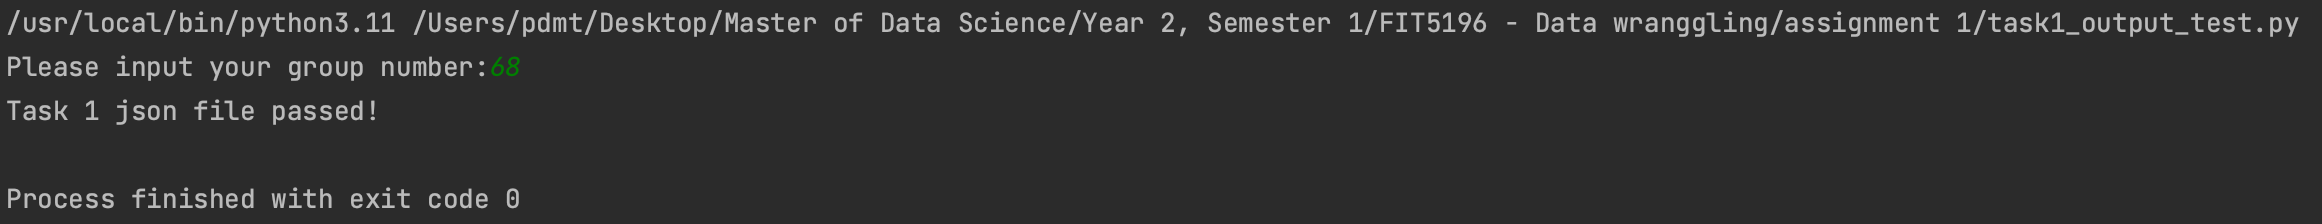

-------------------------------------

<div class="alert alert-block alert-warning">

## 6. Summary <a class="anchor" name="summary"></a>

</div>

The raw data, parsed using regular expressions, revealed structured assignment entries containing details about assignors, assignees, and property count. The required information are successfully extracted in the JSON file that is more readable, accessible for machine.

-------------------------------------

<div class="alert alert-block alert-warning">

## 7. References <a class="anchor" name="Ref"></a>

</div>

[1] Why do I need to add DOTALL to python regular expression to match new line in raw string, https://stackoverflow.com/questions/22610247, Accessed 03/04/2024.

[2] What does the 1 in match.group(1) mean?, https://stackoverflow.com/questions/14909777/what-does-the-1-in-match-group1-mean, Accessed 04/04/2024.

[3] Matching XML tags with Java regular expressions, https://colinchjava.github.io/2023-10-01/17-43-33-264642-matching-xml-tags-with-java-regular-expressions/, Accessed 03/03/2024

[Link to my workspace] (https://colab.research.google.com/drive/1W-tg35qAKb1_x2VBxecqNdtLU067Sgpt#scrollTo=DkSadQUqY8VM)

## --------------------------------------------------------------------------------------------------------------------------